In [1]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats
import statsmodels.api as sm # we need this for our multiple regression

In [2]:
###############################
# start with basic regression #
###############################

#load up the states data
states_data = Table.read_table("states_data.csv")

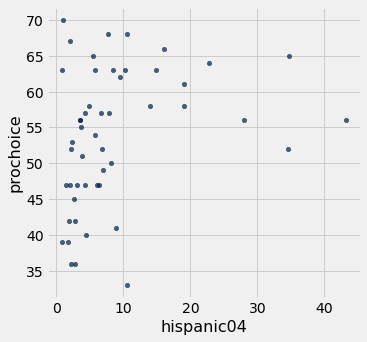

In [3]:
# start with a hypothesis: we think the size of the hispanic population causally affects the % of people who are prochoice.

# draw a scatter plot: prochoice (dep var) and  hispanic population (ind variable)
states_data.scatter('hispanic04', 'prochoice') #looks positive, tho not v strong

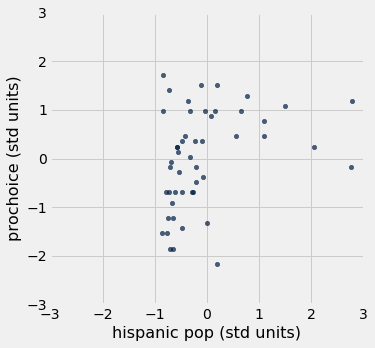

In [4]:
# Perhaps underlying units are confusing.
# So let's remake the plot in terms of standardized units.

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers) 


Table().with_columns( 
     'hispanic pop (std units)', standard_units(states_data.column('hispanic04')),
    'prochoice (std units)',  standard_units(states_data.column('prochoice')),
    
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

In [5]:
# look at the correlations
# first define the correlation function
def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

#then call the function
print("\n correlation btwn prochoice and hispanic popn is", correlation(states_data, "prochoice", "hispanic04") )




 correlation btwn prochoice and hispanic popn is 0.2951820091393328


In [6]:
#verify correlation is symmetric
print("\n correlation btwn hispanic popn and prochoice is", correlation(states_data, "hispanic04", "prochoice") )


 correlation btwn hispanic popn and prochoice is 0.2951820091393328


In [7]:
# rescale the variables, and see if correlation is same
# we'll create stand alone variables to do that
#let's divide prochoice by 2 and subtract 3, add 4.5 to hispanic popn
his2 = (states_data.column("hispanic04"))+4.5
prochoice2 = (states_data.column("prochoice")/2)-3


# put these in a table so we can call our correlation function again
temp_table = Table().with_columns([
      'his2', his2,
     'prochoice2',  prochoice2, ])
 
print("\n correlation btwn his2 and prochoice2 is", correlation(temp_table, "his2", "prochoice2") )
# so, seems linear rescaling did not affect things.    


 correlation btwn his2 and prochoice2 is 0.2951820091393328



 correlation btwn x and y is 0.0


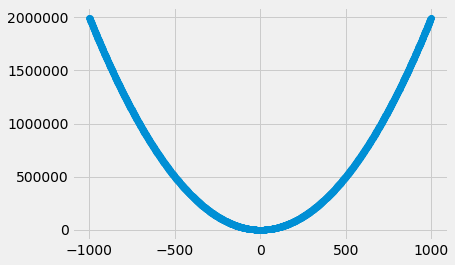

In [8]:
# what can go wrong with correlation?
# let's look at a quadratic equation
# of the form 2x+ 2(x^2)
    
# create x as a series and then just make y the relevant fn of x
x = np.arange(-1000,1000)
y =  2*x + (2*(x**2))

#let's look at the scatterplot:
plots.scatter(x,y)
#definitely a relationship, but looks *non-linear*

#let's use numpy's inbuilt correlation function to look at correlation btwn x and y
# that creates a matrix, but we can just ask for the particular entry of interest
print("\n correlation btwn x and y is", np.corrcoef(x, y)[1,0] )
# which is basically zero.




In [9]:
# #########################
# linear regression

#run a linear regression of prochoice on hispanic % of people
# first, define slope and intercept estimation function
def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

# run regression
model_slope = slope(states_data, 'hispanic04', 'prochoice')
model_intercept = intercept(states_data, 'hispanic04', 'prochoice')
model_intercept, model_slope


(51.008971736917935, 0.30084297129846377)

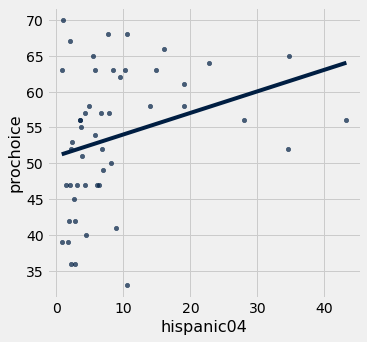

In [10]:
#put the regression line on the scatteplot
def fit(table, x, y):
    """Return the value of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

states_data.scatter('hispanic04', 'prochoice', fit_line=True)

In [11]:
# make a regression prediction for every state
states_with_predictions = states_data.with_column(
    'Regression Prediction', model_slope*states_data.column('hispanic04') + model_intercept
)


#what was prochoice prediction for North Carolina?
states_with_predictions["stateid"]
NCS = states_with_predictions.where(states_with_predictions["stateid"] == 'NC    ')
print("North Carolina predicted pro choice:", NCS["Regression Prediction"],"")

#what was the _actual_ value for North Carolina?
NC_actual = states_data.where(states_data["stateid"]=='NC    ')["prochoice"]
print("North Carolina actual pro choice:", NC_actual,"")


North Carolina predicted pro choice: [52.84411386] 
North Carolina actual pro choice: [47] 


In [12]:
# do some residual plotting/operations

#first define a residual
def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

# what was residual for North Carolina?
NC_resid = residual(states_data, "hispanic04", "prochoice")[states_data["stateid"]=='NC    ']
print("North Carolina regression residual:", NC_resid,"")
#NB: this looks right: NC actual - NC predicted (from above)

North Carolina regression residual: [-5.84411386] 


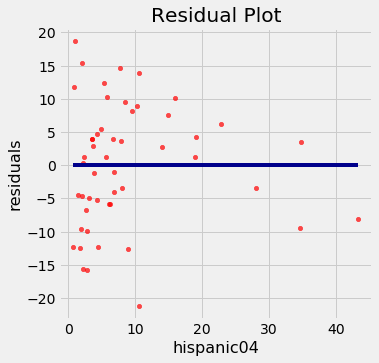

In [13]:
#define a residual plot
def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')
    
# call it on our data
residual_plot(states_data, 'hispanic04', 'prochoice')
# may be a little nonlinearity here, and a some hetroskedasticity

In [14]:
#calc R2 -- tells us the proportion of variance in y explained by 
# our x variable.
def r2(t, x, y):
    return correlation(t, x, y)**2

r2(states_data, "hispanic04", "prochoice")
# so ~9 percent here.

0.08713241851953314

In [15]:
# Let's obtain a 95% confidence interval for the slope

# bootstap func for the slope 
def bootstrap_slope(table, x, y, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter, get the slope of the regression line,
    # augment the list of generated slopes
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)


Slope of regression line: 0.30084297129846377
Approximate 95%-confidence interval for the true slope:
0.10640322617611037 0.6616548232638995


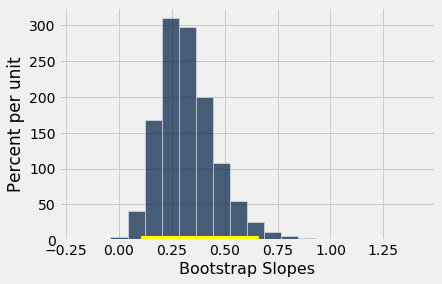

In [16]:
# we will do 4000 repetitions 
bootstrap_slope(states_data, 'hispanic04', 'prochoice', 4000)
# does interval contain zero?

In [17]:
## do some predictive values 
# (actually predicted confidence intervals)

# first define a fitted value
def fitted_value(table, x, y, given_x):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * given_x  + b

# Bootstrap prediction of variable y at new_x
# Data contained in table; prediction by regression of y based on x
# repetitions = number of bootstrap replications of the original scatter plot

def bootstrap_prediction(table, x, y, new_x, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter; 
    # get the regression prediction at new_x; 
    # augment the predictions list
    predictions = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_prediction = fitted_value(bootstrap_sample, x, y, new_x)
        predictions = np.append(predictions, bootstrap_prediction)
        
    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    
    # Prediction based on original sample
    original = fitted_value(table, x, y, new_x)
    
    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)



Height of regression line at x=6: 52.81402956470872
Approximate 95%-confidence interval:
50.14028380943097 55.69593490137938


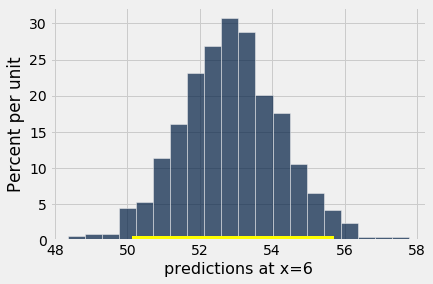

In [18]:
# let's do 1000 repetitions
#what if 6% are hispanic? (abt average in US states)
bootstrap_prediction(states_data, 'hispanic04', 'prochoice', 6, 1000) 

Height of regression line at x=50: 66.05112030184112
Approximate 95%-confidence interval:
58.43897684952206 81.22273386431485


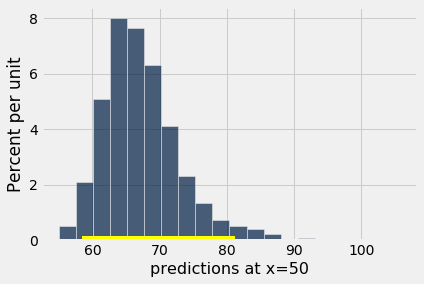

In [19]:
#what if 50% are hispanic? (higher than data max)  -- note that interval is _much_ wider.
bootstrap_prediction(states_data, 'hispanic04', 'prochoice', 50, 1000) 

In [20]:
#####################
## switch to knn    #
#####################

## bunch of functions for knn

def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)




In [21]:
# load the ckd data
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose') #minor relabeling of one column

In [22]:
#reduce to just blood pressure and glucose (only use a couple of variables for now)
# also, let's standardize those variables
ckd_small = Table().with_columns(
    'Blood Pressure', standard_units(ckd.column('Blood Pressure')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'Class', ckd.column('Class')
)


In [23]:
# a little finicky, but this will make sure colors are correct
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd_small = ckd_small.join('Class', color_table)


# and this makes sure that labels correspond to those colors
status_table = Table().with_columns(
    'Class', make_array(1, 0), 
    'status', make_array("CKD","CKD free")
)
ckd_small = ckd_small.join('Class', status_table)

# quick look at our data
ckd_small

Class,Blood Pressure,Glucose,Color,status
0,0.534056,0.133751,gold,CKD free
0,0.534056,-0.947597,gold,CKD free
0,0.534056,-0.762223,gold,CKD free
0,0.534056,-0.190654,gold,CKD free
0,-1.26128,-0.49961,gold,CKD free
0,0.534056,-0.159758,gold,CKD free
0,0.534056,-0.00527964,gold,CKD free
0,-1.26128,-0.623193,gold,CKD free
0,0.534056,-0.515058,gold,CKD free
0,0.534056,-0.422371,gold,CKD free


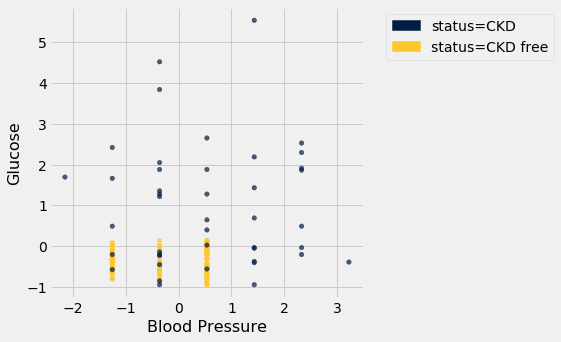

In [24]:
# draw a scatter plot
ckd_small.scatter('Blood Pressure', 'Glucose', group='status')
#hmm, looks like high BP and/or high glucose is bad combination

In [25]:
# create decision boundary

# first let's make a bunch of points that we need to classify
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Blood Pressure', x_array,
    'Glucose', y_array
)


In [26]:
# make function to classify new people
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

#classify all the points with respect to their nearest neighbor 
# (note need to drop color/status variables here)
c = classify_grid(ckd_small.drop('status','Color'), test_grid, 1)

In [27]:
# for test set, have to tell it which "status" each "class" has
test_grid = test_grid.with_column('Class', c).join('Class', status_table)
# quick look at the test set
test_grid

Class,Blood Pressure,Glucose,status
0,-2,-2,CKD free
0,-2,-1.9,CKD free
0,-2,-1.8,CKD free
0,-2,-1.7,CKD free
0,-2,-1.6,CKD free
0,-2,-1.5,CKD free
0,-2,-1.4,CKD free
0,-2,-1.3,CKD free
0,-2,-1.2,CKD free
0,-2,-1.1,CKD free


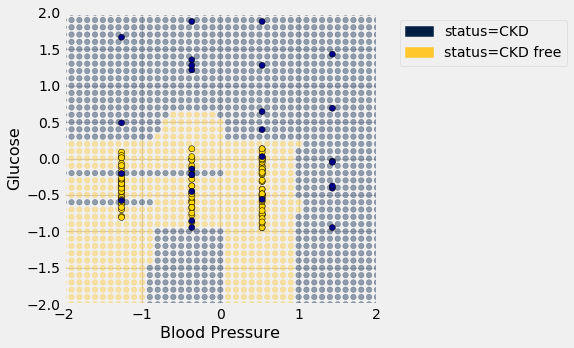

In [28]:
#now draw the test set in terms of its colors (based on NN), but wash it out w alpha coloring
test_grid.scatter('Blood Pressure', 'Glucose', group='status', alpha=0.4, s=30)
# on top of that, plot the *actual* points
plots.scatter(ckd_small.column('Blood Pressure'), ckd_small.column('Glucose'), c=ckd_small.column('Color'), edgecolor='k')
plots.xlim(-2, 2)
plots.ylim(-2, 2); #the boundary is being drawn in the restricted -2,2 space

In [29]:
# example of new patient ("Alice" in the book) 
# this new patient has attributes: bp = -.5 , glucose = -0.2 (standardized)

new_patient = make_array(-.5, -.2 )

#get attributes of interest
ckd_attributes = ckd_small.select('Blood Pressure', 'Glucose')

#take a look at those attributes 
ckd_attributes

Blood Pressure,Glucose
0.534056,0.133751
0.534056,-0.947597
0.534056,-0.762223
0.534056,-0.190654
-1.26128,-0.49961
0.534056,-0.159758
0.534056,-0.00527964
-1.26128,-0.623193
0.534056,-0.515058
0.534056,-0.422371


In [30]:
# create distance functions for knn

# distance function
def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2.
    
    Each argument is an array containing the coordinates of a point."""
    return np.sqrt(np.sum((point1 - point2)**2))


# distance from new patient
def distance_from_new_patient(row):
    """Returns distance between new patient and a row of the attributes table"""
    return distance(new_patient, np.array(row))


# define new variable called distances
distances = ckd_attributes.apply(distance_from_new_patient)

#just drop a couple of extraneous cols
ckd_with_distances = ckd_small.with_column('Distance from New Patient', distances)

#sort these in order of distance
sorted_by_distance = ckd_with_distances.sort('Distance from New Patient')

#look at the data, sorted by distance from the new patient
sorted_by_distance


Class,Blood Pressure,Glucose,Color,status,Distance from New Patient
1,-0.363613,-0.221549,darkblue,CKD,0.138079
1,-0.363613,-0.221549,darkblue,CKD,0.138079
0,-0.363613,-0.175206,gold,CKD free,0.138622
1,-0.363613,-0.14431,darkblue,CKD,0.147319
0,-0.363613,-0.128862,gold,CKD free,0.153825
0,-0.363613,-0.283341,gold,CKD free,0.159835
0,-0.363613,-0.0979666,gold,CKD free,0.17033
0,-0.363613,-0.376028,gold,CKD free,0.222682
0,-0.363613,-0.376028,gold,CKD free,0.222682
0,-0.363613,-0.0207275,gold,CKD free,0.225256


In [31]:
# get closest 1
patient_1_nn = sorted_by_distance.take(np.arange(1))
patient_1_nn
# this person was 0.138 away from our new patient.

Class,Blood Pressure,Glucose,Color,status,Distance from New Patient
1,-0.363613,-0.221549,darkblue,CKD,0.138079


In [32]:
# get closest 3
patient_3_nn = sorted_by_distance.take(np.arange(3))
patient_3_nn 
# what is majority (class) vote?

Class,Blood Pressure,Glucose,Color,status,Distance from New Patient
1,-0.363613,-0.221549,darkblue,CKD,0.138079
1,-0.363613,-0.221549,darkblue,CKD,0.138079
0,-0.363613,-0.175206,gold,CKD free,0.138622


In [33]:
# get closest 7
patient_7_nn = sorted_by_distance.take(np.arange(7))
patient_7_nn
# what is majority (class) vote?

Class,Blood Pressure,Glucose,Color,status,Distance from New Patient
1,-0.363613,-0.221549,darkblue,CKD,0.138079
1,-0.363613,-0.221549,darkblue,CKD,0.138079
0,-0.363613,-0.175206,gold,CKD free,0.138622
1,-0.363613,-0.14431,darkblue,CKD,0.147319
0,-0.363613,-0.128862,gold,CKD free,0.153825
0,-0.363613,-0.283341,gold,CKD free,0.159835
0,-0.363613,-0.0979666,gold,CKD free,0.17033


In [34]:
## looking at accuracy of classifier 

# first need a bunch of functions to tell us distances between observations

# 1. we need distance functions that will tell us the distance between observations:

def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(new_point), np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

# 2. and then a bunch of functions to  take a majority vote, and return a classification
def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)


In [35]:
#let's use our ckd data again, except we'll add albumin as a variable

# standardize variables as before, make smaller more managable data set
ckd_small_p = Table().with_columns(
    'Age', standard_units(ckd.column('Age')),
    'Sodium', standard_units(ckd.column('Sodium')),
    'Albumin', standard_units(ckd.column('Albumin')),
    'Class', ckd.column('Class')
)

# number of observations in our dataset
# this helps us split things into training and test momentarily
nrow = ckd_small_p.num_rows 

# shuffle for training and test
shuffled_ckd = ckd_small_p.sample(with_replacement=False) 
training_set = shuffled_ckd.take(np.arange(int(nrow/2)))
test_set = shuffled_ckd.take(np.arange(int(nrow/2), int(nrow)))

In [36]:
# evaluation functions
def count_zero(array):
    """Counts the number of 0's in an array"""
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length
    and counts the indices where the two are equal"""
    return count_zero(array1 - array2)

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    def classify_testrow(row):
        return classify(training, row, k)
    c = test_attributes.apply(classify_testrow)
    print(count_equal(c, test.column('Class')), "correct predictions out of",test.num_rows,"total predictions")
    return count_equal(c, test.column('Class')) / test.num_rows


In [37]:
# look at column of actual classes of test set
# versus predicted class.
test_attributes = test_set.drop('Class')

#function to classify
def classify_testrow(row):
        return classify(training_set, row, 5)
predict_out = test_attributes.apply(classify_testrow)
actual_class= test_set.select("Class")

#put these together, just so they can be compared.
mod_pred = Table().with_columns('model prediction', predict_out)
table_compare =  mod_pred.append_column('actual class', actual_class[0])

# take a look: do we generally match the actual class with our prediction?
table_compare

model prediction,actual class
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,1
0,0


In [38]:
#evaluate accuracy 
# (this varies depending on the random sample of the training/test set)

# we will evaluate for 5nn model
evaluate_accuracy(training_set, test_set, 5)

76 correct predictions out of 79 total predictions


0.9620253164556962

In [39]:
#what was the most common class in our training set?
uniqueValues, occurCount = np.unique(training_set["Class"], return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Count : ", occurCount)

# this outputs the unique values (0 and 1)
# and the _count_ of those unique values in the training set

#looks like it was zero (not having ckd) was most common

Unique Values :  [0 1]
Count :  [59 20]


In [40]:
# what happens if we guess 0 for everything in our test set?

# well, how many zeros did we have in the test set?
uniqueValues_test, occurCount_test = np.unique(test_set["Class"], return_counts=True)
 
print("Unique Values (test) : " , uniqueValues_test)
print("Count (test) : ", occurCount_test)

# accuracy of modal guess is (number of elements in test set == modal entry in training set)/total number of predictions
npredictions = len(test_set["Class"])
modal_guess_accuracy = occurCount_test[0] / npredictions

print("\nmodal guess accuracy is", modal_guess_accuracy)
# looks like our model is better than guessing here.

Unique Values (test) :  [0 1]
Count (test) :  [56 23]

modal guess accuracy is 0.7088607594936709


In [41]:
#######################
# Multiple regression #
#######################

# load the World data
world = Table.read_table('world_data.csv')

# break into training and test set
nrow_world = world.num_rows # need to know what half data would be

train, test = world.split(int(nrow_world/2))
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

83 training and 83 test instances.


In [42]:
# let's take a look -- what is the first, second, third etc country in data?
world

lifeex_total,gini10,dem_score14,oil,gender_unequal,gdppcap08,literacy,pop_urban,country
45.02,29.4,2.77,0,0.797,1588,28.1,22.6,Afghanistan
77.41,33,5.67,5400,0.545,7715,89.9,51.9,Albania
74.5,35.3,3.83,2.125e+06,0.594,8033,69.9,66.5,Algeria
38.76,58.6,3.35,1.948e+06,0.756,5899,67.4,58.5,Angola
76.95,48.8,6.84,796300,0.534,14333,97.2,92.4,Argentina
73.23,30.2,4.13,0,0.57,6070,99.4,64.2,Armenia
81.81,35.2,9.01,589200,0.296,35677,99,89.1,Australia
79.78,29.1,8.54,21880,0.3,38152,98,67.6,Austria
67.36,36,2.83,1.011e+06,0.553,8765,98.8,51.9,Azerbaijan
78.15,29,2.87,48560,0.512,34605,86.5,88.6,Bahrain


In [43]:
# Want to predict life expectancy, based on
# literacy and urban population (pop_urban)

# let's do a linear regression using statsmodel

# first,  convert the training table to a df
train_df =train.to_df()

# now create y and x such that it can be fed to the .OLS function
y = train_df[["lifeex_total"]]
X = train_df[["literacy","pop_urban"]]

## fit OLS model with intercept on the variables
Xc = sm.add_constant(X)
est = sm.OLS(y, Xc).fit()
print(est.summary())




                            OLS Regression Results                            
Dep. Variable:           lifeex_total   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     58.84
Date:                Wed, 30 Oct 2019   Prob (F-statistic):           1.93e-16
Time:                        11:43:01   Log-Likelihood:                -269.52
No. Observations:                  83   AIC:                             545.0
Df Residuals:                      80   BIC:                             552.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7213      2.733     15.265      0.0

In [44]:
# make _test_ set into a df suitable for .OLS predictions

test_df =test.to_df()
X_test = test_df[["literacy","pop_urban"]] # same variables!

Xnew = sm.add_constant(X_test) # add a constant
ynew =  est.predict(Xnew)#ynew are my predictions for the test set.

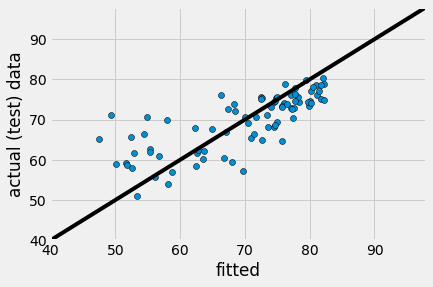

In [45]:
# draw scatterplot
plots.scatter(test_df[['lifeex_total']],ynew, edgecolor="black")
plots.ylabel("actual (test) data")
plots.xlabel("fitted")
plots.xlim(40,98)
plots.ylim(40,98)
plots.plot([-100, 5e5], [-100, 5e5], color="black")
plots.show()
# model does well between 70-80 years LE, but not so well between 50 to 70

In [46]:
# calculate mean square error for model, and then take square root for RMSE

iMSE = np.mean((ynew - test_df['lifeex_total'])**2) # with intercept
print("\n the regression (w intercept) RMSE was:",(iMSE)**.5,"years")


 the regression (w intercept) RMSE was: 6.356830709712411 years


In [47]:
###########################
# compare to NN classifier#


#some useful functions...
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))


def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train2, example, 5, 'lifeex_total').column('lifeex_total'))


In [48]:
#make the predictions
# note we are taking local averages of k numbers
# (this takes a while)

# first tell python what variables we want in the model 
# (same as linear regression presumably)
train2 = train.select("lifeex_total","literacy","pop_urban")
test2 = test.select("literacy","pop_urban")

#then, call the function 
nn_test_predictions = test2.apply(predict_nn)

In [52]:
rmse_nn = np.mean((test.column("lifeex_total") - nn_test_predictions) ** 2) ** 0.5
print("\n RMSE of the nn model is:", rmse_nn, "years")
# looks like regression does v slightly better than nn (tho may depend on sample)


 RMSE of the nn model is: 6.984351217379525 years
